In [7]:
# Standard library imports
import json
import logging
import os
import random
import time
from pathlib import Path

# Third-party imports
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector

# Custom package imports
from pauli_propagation import PauliTerm, PauliPropagator, staircasetopology2d_qc
from pauli_propagation.decomposition import su4_kak_reconstruct
from pauli_propagation.gates import QuantumGate
from pauli_propagation.monte_carlo import MonteCarlo
from pauli_propagation.utils import encode_pauli, random_su4

# Configure logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)
plt.rcParams['figure.dpi'] = 300

In [4]:
rng      = np.random.default_rng(seed=42)  # Set random seed

nq = 5
qc = QuantumCircuit(nq)

pairs = [(0, 1), (1, 2), (2, 3), (3, 4)]
for _ in range(4):
    for q1, q2 in pairs:
        gname  = rng.choice(["rxx", "ryy", "rzz"])
        theta  = rng.uniform(np.pi/6, 5*np.pi/6)
        getattr(qc, gname)(theta, q1, q2)   # call qc.rxx / ryy / rzz

init_key  = encode_pauli(Pauli("Z" + "I" * (nq - 1)))
init_term = PauliTerm(1.0, init_key, nq)

prop = PauliPropagator(qc)
mc   = MonteCarlo(qc)

out_dir     = f"results/example"
os.makedirs(out_dir, exist_ok=True)
sample_file = os.path.join(out_dir, "mc_samples.pkl")

mc.monte_carlo_samples(init_term = init_term, 
                       M = 100000,
                       sample_file = sample_file, 
                       load_existing = True)

mse_mc_results_dict = mc.estimate_mse_for_truncation(propagator = prop, product_label =  "0" * nq,)

mse_dict = mse_mc_results_dict["MSE"]
var_dict = mse_mc_results_dict["Var"]

sqrt_var_dict = {k: np.sqrt(v) for k, v in var_dict.items()}
# 打印 (k, MSE, sqrt(Var))
print(f"{'k':<3} {'MSE':<10} {'sqrt(Var)':<12}")
for k in mse_dict.keys():
    mse_val = mse_dict[k]
    sqrt_var_val = sqrt_var_dict[k]
    print(f"{k:<3} {mse_val:<10.5g} {sqrt_var_val:<12.5g}")

Loading existing samples from results/example\mc_samples.pkl...
Loaded 100000 existing samples
Already have 100000 samples, no new sampling needed
k   MSE        sqrt(Var)   
0   0.30703    0.0014586   
1   0.10396    0.00096516  
2   0.01226    0.00034799  
3   0.00022    4.6899e-05  
4   0          0           
5   0          0           
6   0          0           


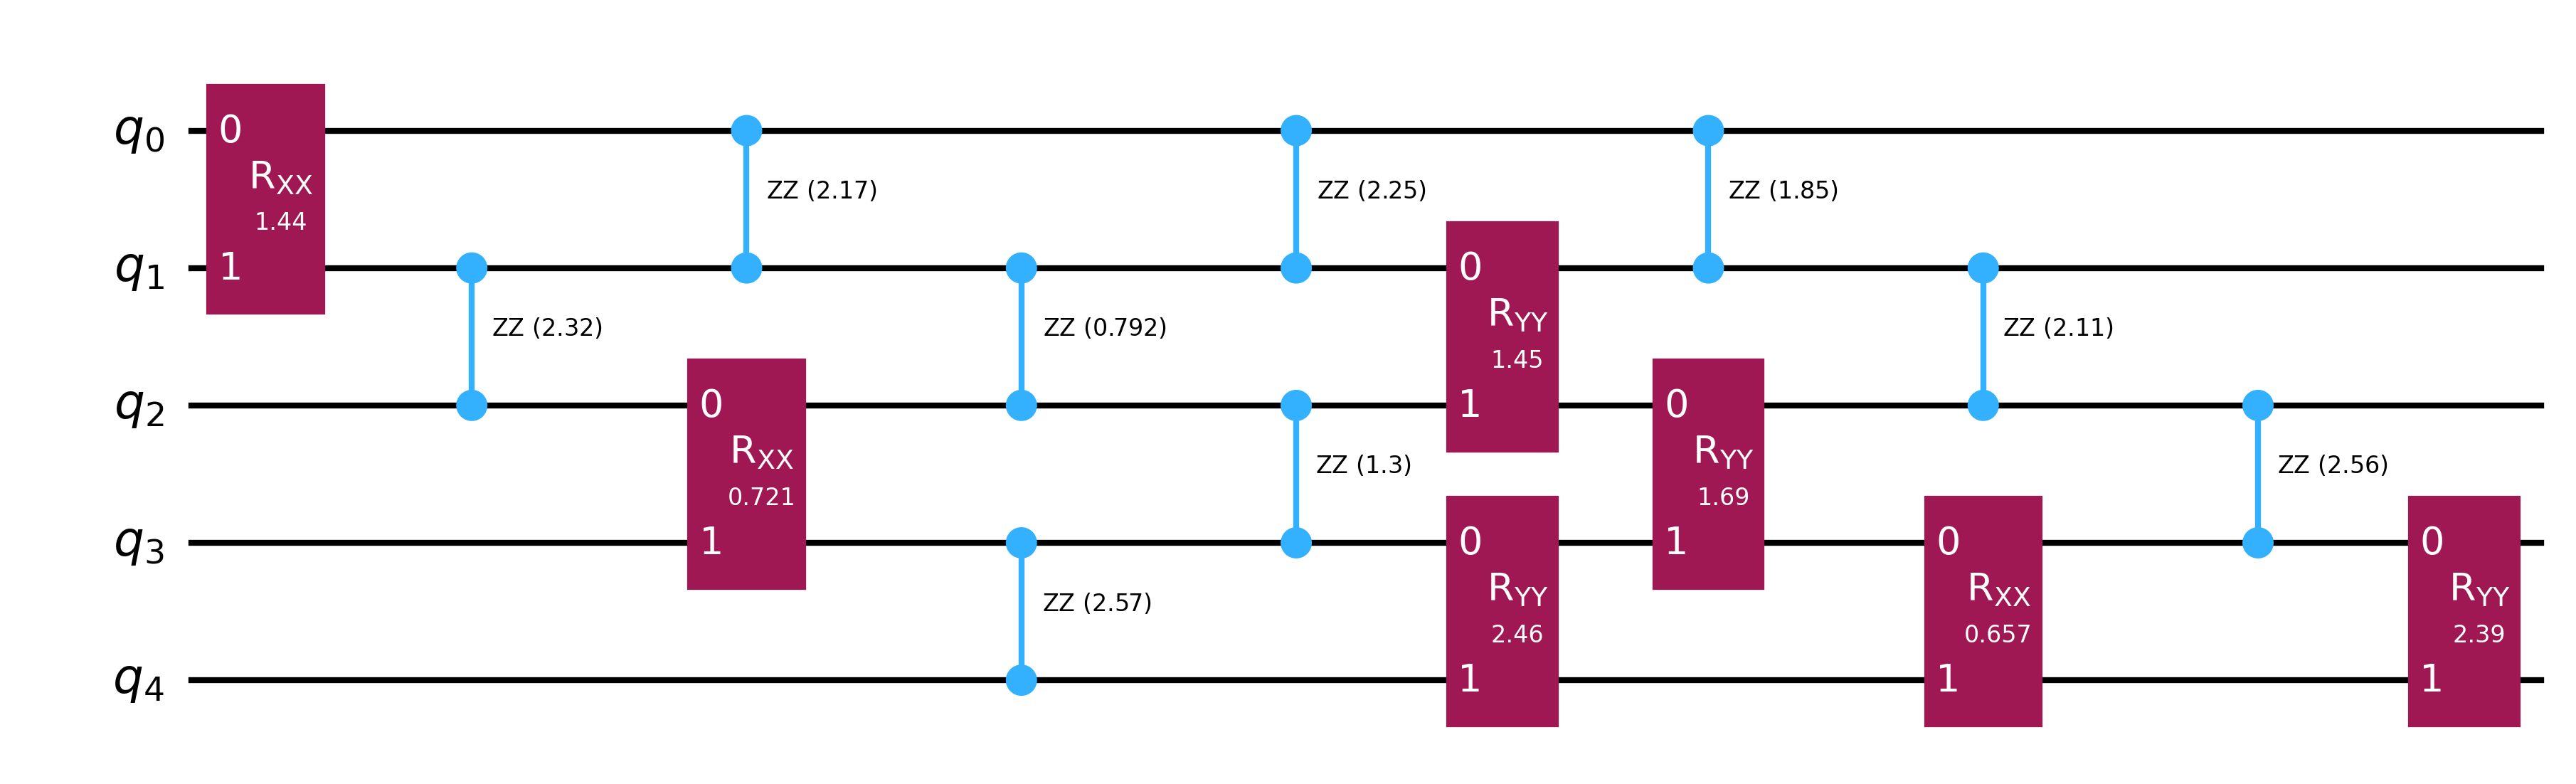

In [4]:
qc.draw("mpl", fold=-1);

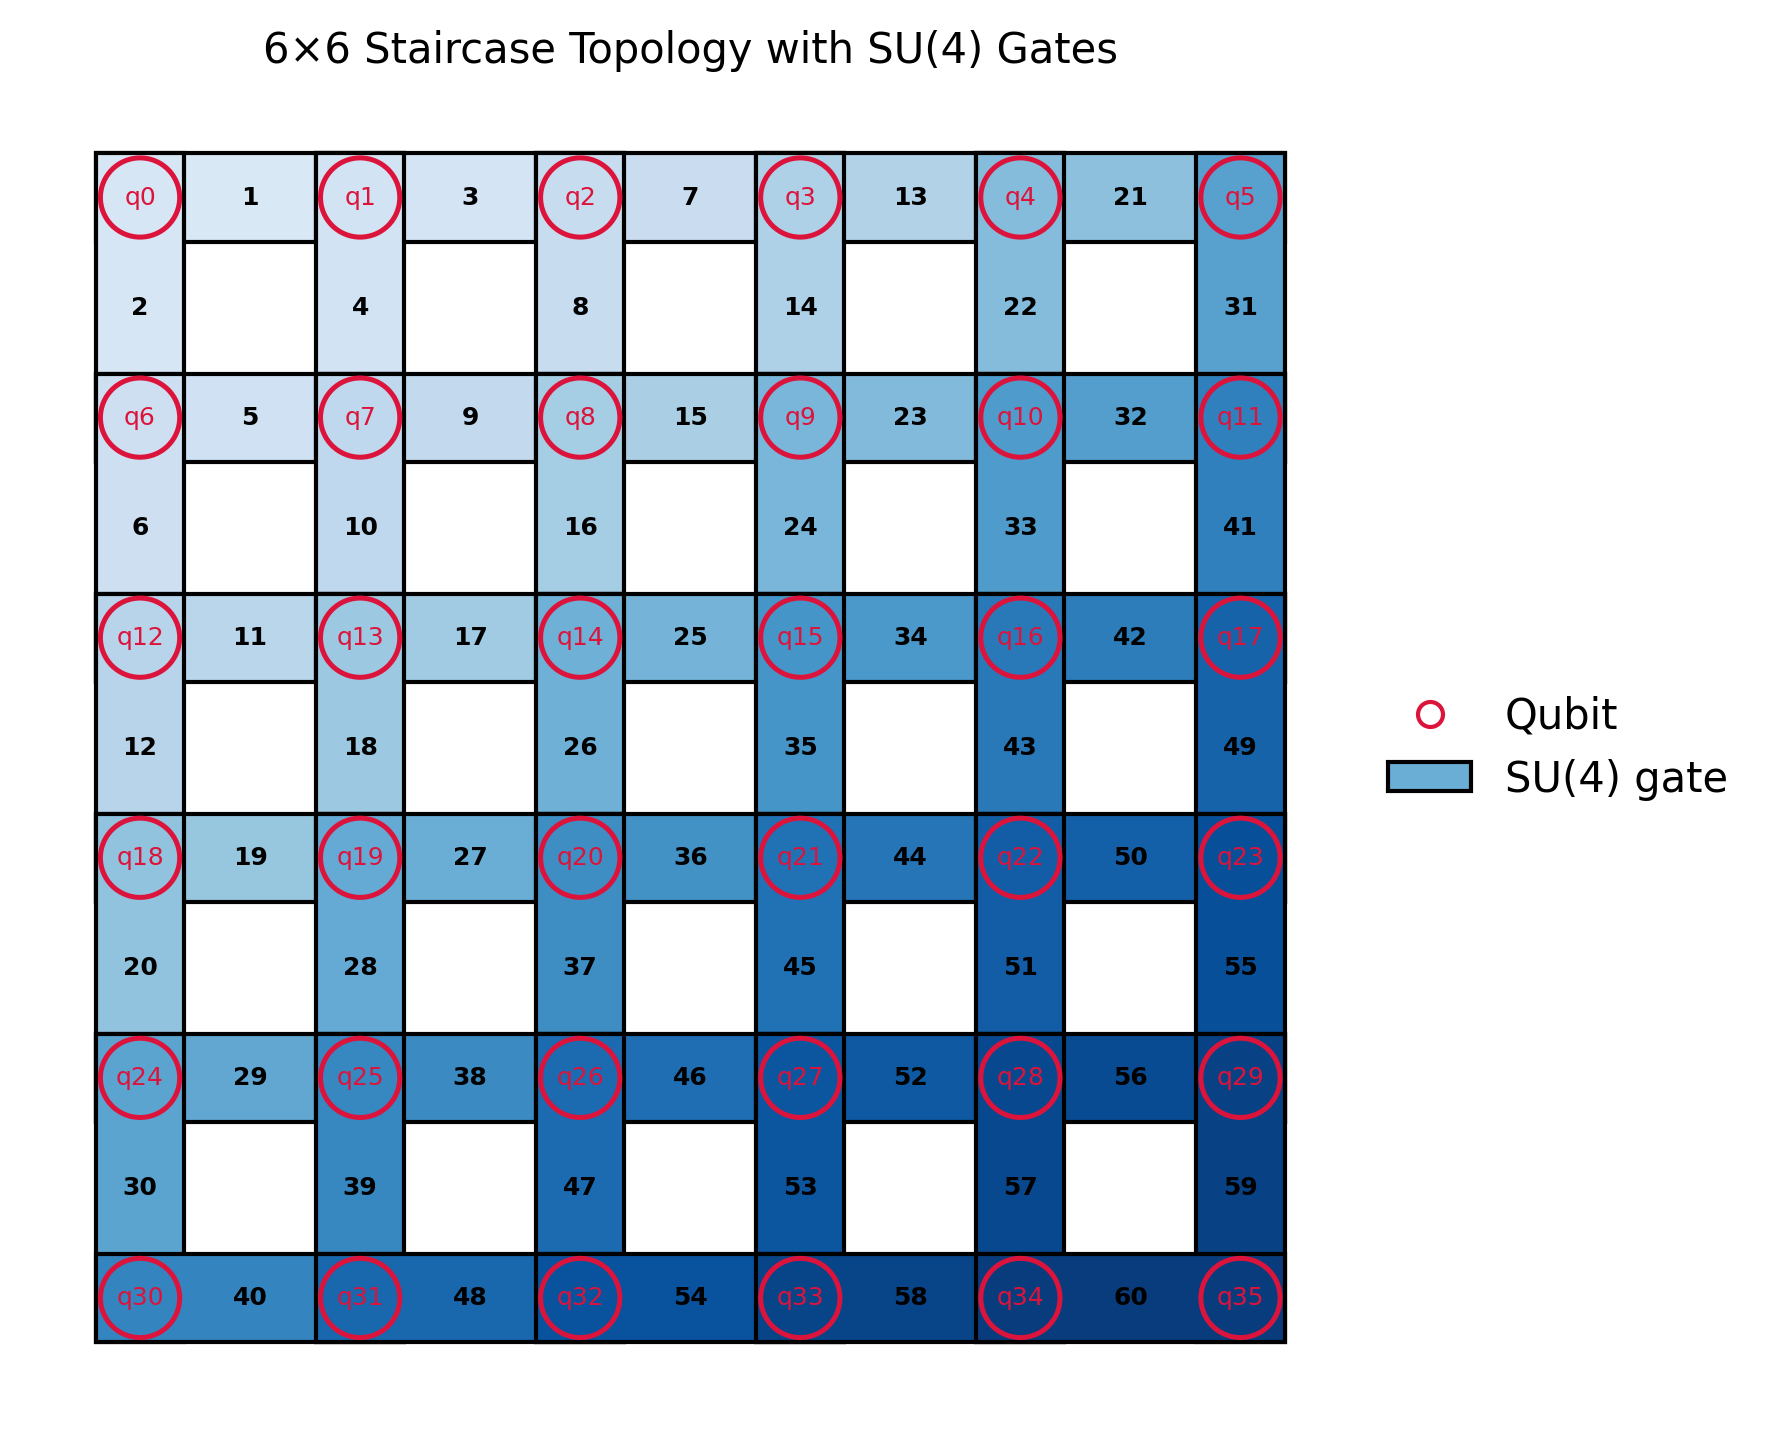

In [5]:


# -------- staircase edge list (1-based indices) ----------
def staircase_edges(nx, ny):
    nxt, tmp, edges = [1], [], []
    while nxt:
        for i in nxt:
            if i % nx:                 # right
                n = i + 1; edges.append((i, n)); tmp.append(n)
            if (i - 1)//nx + 1 < ny:   # down
                n = i + nx; edges.append((i, n)); tmp.append(n)
        nxt, tmp = tmp, []
    uniq, seen = [], set()
    for e in edges:
        if e not in seen:
            seen.add(e); uniq.append(e)
    return uniq
# ---------------------------------------------------------

nx, ny = 6,6
edges   = staircase_edges(nx, ny)
N       = len(edges)

spacing = 1.          # distance between qubits
long, short = 1.4, 0.4  # gate rectangle sizes

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect("equal")
ax.axis("off")

# color map light → dark
cmap   = plt.cm.Blues
colors = [cmap(0.15 + 0.8 * i / (N - 1)) for i in range(N)]

# draw SU(4) gate rectangles (bottom layer)
for idx, (q1, q2) in enumerate(edges, 1):
    q1 -= 1; q2 -= 1
    x1, y1 = spacing*(q1 % nx), spacing*(ny - 1 - q1//nx)
    x2, y2 = spacing*(q2 % nx), spacing*(ny - 1 - q2//nx)
    xm, ym = (x1 + x2)/2, (y1 + y2)/2
    if y1 == y2:   # horizontal
        rect = patches.Rectangle((xm - long/2, ym - short/2), long, short,
                                 facecolor=colors[idx-1], edgecolor='k', linewidth=1)
    else:          # vertical
        rect = patches.Rectangle((xm - short/2, ym - long/2), short, long,
                                 facecolor=colors[idx-1], edgecolor='k', linewidth=1)
    ax.add_patch(rect)
    ax.text(xm, ym, str(idx), ha='center', va='center',
            fontsize=6, color='black', weight='bold')

# draw hollow qubit circles with indices (top layer)
circle_radius = 0.18
for q in range(nx*ny):
    x = spacing * (q % nx)
    y = spacing * (ny - 1 - (q // nx))
    circ = patches.Circle((x, y), radius=circle_radius,
                          facecolor='none', edgecolor='crimson', linewidth=1.2)
    ax.add_patch(circ)
    ax.text(x, y, f"q{q}", ha='center', va='center',
            fontsize=6, color='crimson')
# frame limits
pad = 0.5
ax.set_xlim(-pad, spacing*(nx - 1) + pad)
ax.set_ylim(-pad, spacing*(ny - 1) + pad)

qubit_handle = Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='none', markeredgecolor='crimson', linewidth=1.2,
                      label='Qubit')
gate_handle = patches.Patch(facecolor=cmap(0.5), edgecolor='k', label='SU(4) gate')
ax.legend(handles=[qubit_handle, gate_handle],
          loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.title("6×6 Staircase Topology with SU(4) Gates", fontsize=10)
plt.tight_layout()
plt.show()


In [6]:
# This cell initializes a 2D random su4 staircase quantum and calculates the expectation value.

nx ,ny = 1,2
L = 1

# Initialize the 2D quantum circuit and the initial Pauli term

qc_2d = staircasetopology2d_qc(nx, ny, L)

n = qc_2d.num_qubits
pauli_label = 'Z' + "I" * (n - 1)  
key = encode_pauli(Pauli(pauli_label))
init_term = PauliTerm(1.0, key, n)
product_label = "0" * n
prop_2d = PauliPropagator(qc_2d)

# Propagate the Pauli term through the circuit
history_2d = prop_2d.propagate(init_term, 
                               max_weight=None, 
                               use_parallel=False,
                               history = False)

# # Calculate the expectation value
exp_2d = prop_2d.expectation_pauli_sum(history_2d, product_label)
print(exp_2d)